In [2]:
import numpy as np
import matplotlib.pyplot as plt
import finesse
from finesse.analysis.actions import RunLocks, Noxaxis
from finesse import ligo
from LLOF3Sqz import make_LLO
from scipy.optimize import curve_fit

finesse.configure(plotting=True)

In [3]:
LLO = finesse.Model()
LLO.parse_file("./LIGO_degisn.txt")
# LLO.Mloss.value = 3.75e-05 
LLO.parse("""
###########################################################################
### SQZ path FTblock squeezer
sq sqz db=3 angle=90
#l sqz 0 0

s sqz_M1_OPO sqz.p1 M1_OPO.p1 0

bs M1_OPO R=0 T=1 phi=0 alpha=6

s subM1_OPO M1_OPO.p3 M1_OPO_AR.p1 L=6.35 nr=&nsilica
bs M1_OPO_AR R=0 T=1 phi=0 alpha=6
s lM1_OPO_EDGE M1_OPO_AR.p3 OPO_EDGE.p1 44m
m OPO_EDGE R=0 T=1 phi=0

# edge of OPO block
s lsqz_lens1 OPO_EDGE.p2 sqz_lens1.p1 0

lens sqz_lens1 1

s lsqz_lens1_faraday sqz_lens1.p2 msqz_faraday_a.p1 0

# 20 mm TGG faraday crystal
m msqz_faraday_a R=0 T=1 phi=0
s lsqz_faraday msqz_faraday_a.p2 msqz_faraday_b.p1 L=20m nr=1.95 
m msqz_faraday_b R=0 T=1 phi=0

s lsqz_faraday_lens2 msqz_faraday_b.p2 sqz_lens2.p1 0

lens sqz_lens2 1
s lsqz_lens2_zm1 sqz_lens2.p2 ZM1.p1 0

bs ZM1 T=0 L=0 phi=0 alpha=45
s lzm1_zm2 ZM1.p2 ZM2.p1 1.0

bs ZM2 T=0 L=0 phi=0 alpha=45
s lzm2_OFI ZM2.p2 OFI.p2 0
""")

# print(LLO.unparse())
LLO = make_LLO(LLO)

In [4]:
LLOQNLS = LLO.deepcopy()

LLOQNLS.parse("""
###########################################################################
### pendulum for QRPN
variable Mitmy 39.420 
variable Metmy 39.642
variable Mitmx 39.603
variable Metmx 39.508

pendulum itmx_sus ITMX.mech mass=&Mitmx fz=1 Qz=1M
pendulum etmx_sus ETMX.mech mass=&Metmx fz=1 Qz=1M
pendulum itmy_sus ITMY.mech mass=&Mitmy fz=1 Qz=1M
pendulum etmy_sus ETMY.mech mass=&Metmy fz=1 Qz=1M

fsig(1)
sgen darmx LX.h
sgen darmy LY.h phase=180

qnoised qnoise OMC_OC.p3.o nsr=True
variable FC_detune 100 # Hz
""")

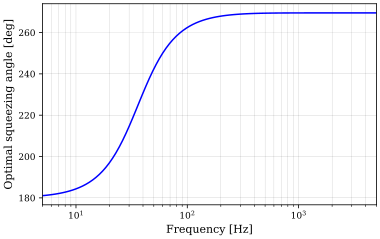

In [5]:
LLOQNLSOptimize = LLOQNLS.deepcopy()
sol_opt_sqz = LLOQNLSOptimize.run("xaxis(darmx.f, log, 5, 5k, 100, pre_step=minimize(qnoise, sqz.angle))")

opt_angle = sol_opt_sqz["pre_step", "minimize"].x
plt.semilogx(sol_opt_sqz.x1, opt_angle)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Optimal squeezing angle [deg]");

$$
\phi=\phi_{0}+\arctan \left(\frac{sig_f^{2}-\delta_f^{2}}{sig_f^{2}+\delta_f^{2}}\right)
$$

where $sig_f$ is the signal frequency, $\delta_f$ is detuning frequency which specifies at what frequency the squeezed state rotates. 

$\phi_{0}$ and $\delta_f$ are free to tune.

[224.70149938  35.89633545]


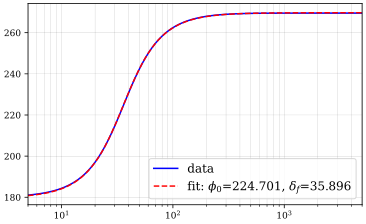

In [9]:
def func(x, offset, delta_f):
    return (offset + 180/np.pi*np.arctan((x**2-delta_f**2)/(x**2 + delta_f**2)))

xdata = sol_opt_sqz.x1.flatten()
ydata = opt_angle.flatten()
popt, pcov = curve_fit(func, xdata, ydata, bounds=([0, 0], [360, 100])) 
# Constrain the optimization to the region of 0 <= offset <= 360, 0 <= delta_f <= 100

plt.semilogx(xdata, ydata, 'b-', label='data')
plt.semilogx(xdata, func(xdata, *popt), 'r--',
         label=r'fit: $\phi_{0}$=%5.3f, $\delta_f$=%5.3f' % tuple(popt))
plt.legend(fontsize=12, loc="best");
print(popt)

In [7]:
LLOQNLSSymbolic = LLOQNLS.deepcopy()
LLOQNLSSymbolic.FC_detune.value = 35.86548139
# Give the variable references shorter names
fsig = LLOQNLSSymbolic.fsig.f.ref
delta_f = LLOQNLSSymbolic.FC_detune.ref
# set the squeezing angle to be a symbolic function
LLOQNLSSymbolic.sqz.angle = (
    224.67593559 + 180/np.pi * np.arctan((fsig**2-delta_f**2)/(fsig**2 + delta_f**2))
)
#         print(LLOQNLS.sqz.angle) # print to see how it turned out
sol_fc_sqz = LLOQNLSSymbolic.run("xaxis(fsig, log, 5, 5k, 100)")

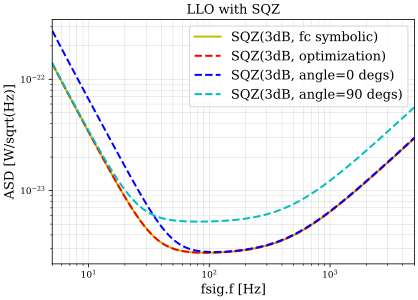

In [8]:
strain_sensitivityF2WithSQZ_0degs = np.load("../F2 code/strain_sensitivityF2WithSQZ_0degs.npy") 
strain_sensitivityF2WithSQZ_90degs = np.load("../F2 code/strain_sensitivityF2WithSQZ_90degs.npy")

x = np.logspace(np.log10(5), np.log10(5000), num=101)

fig,ax =plt.subplots(1,1,figsize=(6.5,4.5))

ax.loglog(x, sol_fc_sqz["qnoise"].real, 'y', lw=2, label='SQZ(3dB, fc symbolic)')
ax.loglog(x, sol_opt_sqz["qnoise"].real, 'r--',lw=2, label='SQZ(3dB, optimization)')
ax.loglog(x, strain_sensitivityF2WithSQZ_0degs, 'b--',lw=2, label='SQZ(3dB, angle=0 degs)')
ax.loglog(x, strain_sensitivityF2WithSQZ_90degs, 'c--',lw=2, label='SQZ(3dB, angle=90 degs)')


ax.set_title("LLO with SQZ", fontsize=13)
ax.set_ylabel("ASD [W/sqrt(Hz)]", fontsize=13)
ax.legend(loc = 'best', fontsize=13, ncol=1)

# ax.set_ylabel("The difference", fontsize=13)
ax.set_xlabel("fsig.f [Hz]", fontsize=13);
# fig.savefig('./withSQZ.pdf')